## <center>Курсовая работа</center>
### Постановка задачи
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту.
### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)
### Содержание ноутбука
1. [Подключение библиотек](#libraries)
2. [Функци](#func)
    * [Обработка данных](#func_processing)
    * [Визуализация](#func_visual)
    * [Подсчет метрик](#func_scores)
3. [Класс обработки данных](#class_processing)
4. [Анализ данных](#analysis)
    * [Преобразование категориальных признаков в числовые](#cat_to_num)
    * [Анализ целевой переменной](#analysis_target)
    * [Анализ категориальных признаков](#analysis_cat)
    * [Анализ числовых признаков](#analysis_num)
    * [Матрица корреляции](#corr_matrix)
5. [Обработка данных](#processing)
6. [Отбор признаков](#select_features)
7. [Обучение модели](#predict)
8. [Анализ качества полученной модели](#analysis_model)
    * [Важность признаков](#feature_importances)
    * [Качество предсказаний](#model_quality)

### <center>Подключение библиотек<a id="libraries"></a><center>

In [81]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, make_scorer

import catboost as catb
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### <center>Функции<a id="func"></a><center>

#### Обработка данных<a id="func_processing"></a>

In [82]:
def imputer_rfr(df, target_col):
 
    data = df.copy()
    features = data.select_dtypes(['float64', 'int64']).columns
    target = data[target_col]
    data = data[features]
    data.dropna(axis=1, inplace=True)
    data.drop(columns='Credit Default', inplace=True)
    data[target_col] = target
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)

    model = catb.CatBoostRegressor(silent=True,
                                   depth=9,
                                   iterations=200,
                                   learning_rate=0.05)

    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    df.loc[df[target_col].isna(), target_col] = list(pred)
    return model, df

#### Визуализация<a id="func_visual"></a>

In [83]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [84]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.5, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [85]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [86]:
def sns_boxplot(df, feature):
    plt.figure(figsize=(6, 3))
    sns.boxplot(df[feature], whis=1.5)
    plt.xlabel(feature)
    plt.show()

In [87]:
def distribution(df, feature, height):
    target_mean = round(df.mean(), 2)
    target_median = df.median()
    target_mode = df.mode()[0]

    plt.figure(figsize = (16, 8))

    sns.distplot(df, bins=50)

    y = np.linspace(0, height, 10)
    plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
    plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
    plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

    plt.title(feature)
    plt.legend()
    plt.show()

In [88]:
def point_plot(df, y, x='Credit Default' ):
    plt.figure(figsize=(8, 5))
    sns.pointplot(x=x, y=y, data=df[[y, x]], capsize=.1)
    plt.show()

In [89]:
def dis_plot(data, feature, x='Credit Default'):
    df = data[feature]
    target_mean = round(df.mean(), 2)
    target_median = df.median()
    target_mode = df.mode()[0]
    height=0.0000005
    
    figure = plt.figure(figsize = (25, 5))

    plt1 = figure.add_subplot(121)
    sns.distplot(df, bins=50)
    y = np.linspace(0, height, 10)
    plt1.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
    plt1.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
    plt1.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)
   
    plt2 = figure.add_subplot(122)
    sns.boxplot(data[feature], whis=1.5)
    
    plt.show()

#### Подсчет метрик<a id="func_scores"></a>

In [90]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))                                                    

In [91]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [92]:
def test_predict(model, test):
    y_test = model.predict(test)
    submit = pd.DataFrame({'Id': np.arange(2500), 'Credit Default': y_test})
    submit.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')
    print('CSV file ready')

### <center>Класс обработки данных<a id="class_processing"></a><center>

In [93]:
class Data:
    
    def __init__(self):
        self.medians = None
        self.medians_0 = None
        self.medians_1 = None

        self.model_annual = None
        self.model_score = None
        
        self.years_to_int = {'10+ years': 10, '8 years': 8, '6 years': 6, '7 years': 7, '5 years': 5,
                             '1 year': 1, '< 1 year': 0, '4 years': 4, '3 years': 3, '2 years': 2, '9 years': 9}
        self.term_dict = {'Short Term': 0, 'Long Term': 1}
    
    def fit(self, df):
        # Подсчет медиан
        self.medians = df.median()
        self.medians_0 = df[df['Credit Default'] == 0].median()
        self.medians_1 = df[df['Credit Default'] == 1].median()
        
        temp = df.copy()
        feature = 'Years in current job'
        temp[feature].replace(to_replace=self.years_to_int, inplace=True)
        
        self.medians[feature] = temp[feature].median()
        self.medians_0[feature] = temp.loc[df['Credit Default'] == 0, feature].median()
        self.medians_1[feature] = temp.loc[df['Credit Default'] == 1, feature].median()
        
    def __fill_median_train(self, df, feature, direction, value=0):
        assert (direction in ['more', 'less', 'fillna', 'max']), 'direction must be in more, less, fillna'
        
        condition_0 = df['Credit Default'] == 0
        condition_1 = df['Credit Default'] == 1
        
        if direction == 'more':
            df.loc[(df[feature] > value) & condition_0, feature] = self.medians_0[feature]
            df.loc[(df[feature] > value) & condition_1, feature] = self.medians_1[feature]
        elif direction == 'less':
            df.loc[(df[feature] < value) & condition_0, feature] = self.medians_0[feature]
            df.loc[(df[feature] < value) & condition_1, feature] = self.medians_1[feature]
        elif direction == 'fillna':
            df.loc[condition_0, feature] = df.loc[condition_0, feature].fillna(value=self.medians_0[feature])
            df.loc[condition_1, feature] = df.loc[condition_1, feature].fillna(value=self.medians_1[feature])
        elif direction == 'max':
            df.loc[df[feature] > value, feature] = value

        return df
    
    def __fill_median_test(self, df, feature, direction, value=0):
        assert (direction in ['more', 'less', 'fillna', 'max']), 'direction must be in more, less, fillna'
        
        if direction == 'more':
            df.loc[df[feature] > value, feature] = self.medians[feature]
        elif direction == 'less':
            df.loc[df[feature] < value, feature] = self.medians[feature]
        elif direction == 'fillna':
            df[feature] = df[feature].fillna(value=self.medians[feature])
        elif direction == 'max':
            df.loc[df[feature] > value, feature] = value

        return df
    
    def __autocomplete(self, df):
        _ = df.columns[df.isna().any()].tolist()
        
        for target_col in _:
            model, df = imputer_rfr(df, target_col)            
            if target_col == 'Annual Income':
                self.model_annual = model
            elif target_col == 'Credit Score':
                self.model_score = model
        
        return df
    
    def __autocomplete_test(self, df):
        _ = df.columns[df.isna().any()].tolist()
        features = df.select_dtypes(['float64', 'int64']).columns
        
        for target_col in _:
            predict_data = df[df[target_col].isna()]
            predict_data = predict_data[features]
            predict_data.dropna(axis=1, inplace=True)

            if target_col == 'Annual Income':
                pred = self.model_annual.predict(predict_data)
            elif target_col == 'Credit Score':
                pred = self.model_score.predict(predict_data)
            
            df.loc[df[target_col].isna(), target_col] = list(pred)
            
        return df
    
    def transform_train(self, df):
        
        df.drop(columns='Months since last delinquent', inplace=True)
        
        # Years in current job
        df['Years in current job'].replace(to_replace=self.years_to_int, inplace=True)
        df = self.__fill_median_train(df, 'Years in current job', 'fillna')
        
        # Bankruptcies
        df = self.__fill_median_train(df, 'Bankruptcies', 'fillna')
        
        # Term
        df['Term'].replace(to_replace=self.term_dict, inplace=True)
        
        # Home Ownership
        df.loc[df['Home Ownership'].isin(['Have Mortgage', 'Home Mortgage']), 'Home Ownership'] = 'Mortgage'
        
        # Выбросы
        df = self.__fill_median_train(df, 'Annual Income', 'more', 0.4 * 10 ** 7)
        df = self.__fill_median_train(df, 'Tax Liens', 'max', 2)
        df = self.__fill_median_train(df, 'Number of Open Accounts', 'more', 24)
        df = self.__fill_median_train(df, 'Years of Credit History', 'more', 40)
        df = self.__fill_median_train(df, 'Maximum Open Credit', 'more', 0.2 * 10 ** 7)
        df = self.__fill_median_train(df, 'Number of Credit Problems', 'max', 2)
        df = self.__fill_median_train(df, 'Bankruptcies', 'max', 2)
        df = self.__fill_median_train(df, 'Current Loan Amount', 'more', 99999990)
        df = self.__fill_median_train(df, 'Current Credit Balance', 'more', 1.5 * 10 ** 6)
        df = self.__fill_median_train(df, 'Monthly Debt', 'more', 60000)    
        
        # Заполнение пропусков при помощи модели
        df = self.__autocomplete(df)
        
        return df
    
    def transform_test(self, df):
        
        df.drop(columns='Months since last delinquent', inplace=True)
        
        # Years in current job
        df['Years in current job'].replace(to_replace=self.years_to_int, inplace=True)
        df = self.__fill_median_test(df, 'Years in current job', 'fillna')
        
        # Bankruptcies
        df = self.__fill_median_test(df, 'Bankruptcies', 'fillna')
        
        # Term
        df['Term'].replace(to_replace=self.term_dict, inplace=True)
        
        # Home Ownership
        df.loc[df['Home Ownership'].isin(['Have Mortgage', 'Home Mortgage']), 'Home Ownership'] = 'Mortgage'
        
        # Выбросы
        df = self.__fill_median_test(df, 'Annual Income', 'more', 0.4 * 10 ** 7)
        df = self.__fill_median_test(df, 'Tax Liens', 'max', 2)
        df = self.__fill_median_test(df, 'Number of Open Accounts', 'more', 24)
        df = self.__fill_median_test(df, 'Years of Credit History', 'more', 40)
        df = self.__fill_median_test(df, 'Maximum Open Credit', 'more', 0.2 * 10 ** 7)
        df = self.__fill_median_test(df, 'Number of Credit Problems', 'max', 2)
        df = self.__fill_median_test(df, 'Bankruptcies', 'max', 2)
        df = self.__fill_median_test(df, 'Current Loan Amount', 'more', 99999990)
        df = self.__fill_median_test(df, 'Current Credit Balance', 'more', 1.5 * 10 ** 6)
        df = self.__fill_median_test(df, 'Monthly Debt', 'more', 60000)

        # Заполнение пропусков при помощи модели
        df = self.__autocomplete_test(df)
            
        return df
    
    def feature_generator(self, df):
        
        # dummies переменные
        for cat_colname in df.select_dtypes(include='object').columns[:1]:
            df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
        
        # Преобразование типов
        df_float_64 = df.select_dtypes(include=['float64', 'bool']).columns
        for column in df_float_64:
            df[column] = df[column].astype(int)
            
        # Объединение признаков в Purpose
        business = ['small business', 'business loan']
        educational = ['educational expenses']
        other = ['debt consolidation', 'other', 'home improvements', 'take a trip',
               'buy a car', 'wedding', 'buy house', 'medical bills', 'moving',
               'major purchase', 'vacation']
        energy = ['renewable energy']

        df.loc[df['Purpose'].isin(business), 'Purpose'] = 'business'
        df.loc[df['Purpose'].isin(educational), 'Purpose'] = 'educational'
        df.loc[df['Purpose'].isin(other), 'Purpose'] = 'other'
        df.loc[df['Purpose'].isin(energy), 'Purpose'] = 'energy'
        
        return df

### <center>Анализ данных<a id="analysis"></a><center>

In [94]:
df = pd.read_csv('course_project_train.csv')
test = pd.read_csv('course_project_test.csv')

df.info()

# В датасете имеются пропуски
# Months since last delinquent заполнять не будем, так как данных слишком мало, а заполнение приводит только к ухудшению метрик
#     К тому же значения в нем распределены так, что нет корреляции с целевой переменной
# Признаки Years in current job и Bankruptcies будут заполнены медианными значениями, так как в них присутствует небольшое количество пропусков
# Признаки Annual Income и Credit Score будут заполнены при помощи модели RandomForestRegressor, так как в них пропусков много
#     и заполнение любыми средними портит распределение.
#     Заполнение признака Months since last delinquent при заполнение при помощи модели дает плохие результаты
#     и только ухудшает качество заполнение двух других признаков при помощи модели

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Преобразование категориальных признаков в числовые<a id="cat_to_num"></a>

In [95]:
years_to_int = {'10+ years': 10, '8 years': 8, '6 years': 6, '7 years': 7, '5 years': 5,
                '1 year': 1, '< 1 year': 0, '4 years': 4, '3 years': 3, '2 years': 2, '9 years': 9}
term_dict = {'Short Term': 0, 'Long Term': 1}

df['Years in current job'].replace(to_replace=years_to_int, inplace=True)
df['Term'].replace(to_replace=term_dict, inplace=True)
df.loc[df['Home Ownership'].isin(['Have Mortgage', 'Home Mortgage']), 'Home Ownership'] = 'Mortgage' # Убираем опечатку в данных

In [96]:
num_features = df.select_dtypes(include=['float64', 'int64']).columns
cat_features = df.drop(columns=num_features).columns
target = 'Credit Default'
num_features = num_features.drop(target)

#### Анализ целевой переменной<a id="analysis_target"></a>

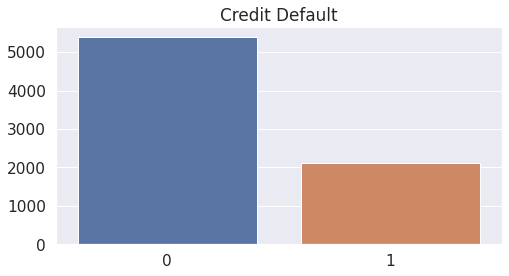

In [97]:
counts = df['Credit Default'].value_counts()
    
plt.figure(figsize=(8,4))    
plt.title('Credit Default')
sns.barplot(counts.index, counts.values)
    
plt.show()

# Имеется дисбаланс данных

#### Анализ категориальных признаков<a id="analysis_cat"></a>

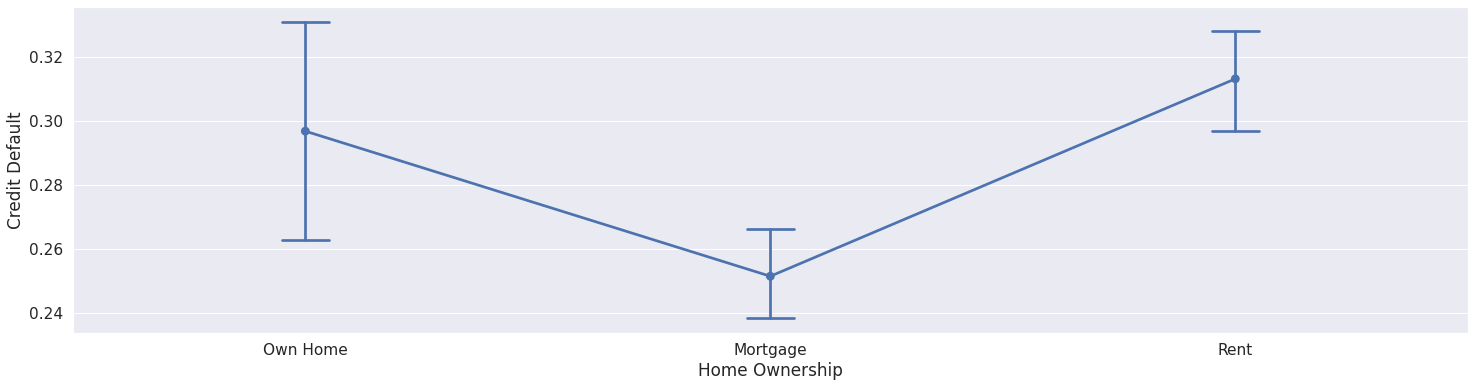

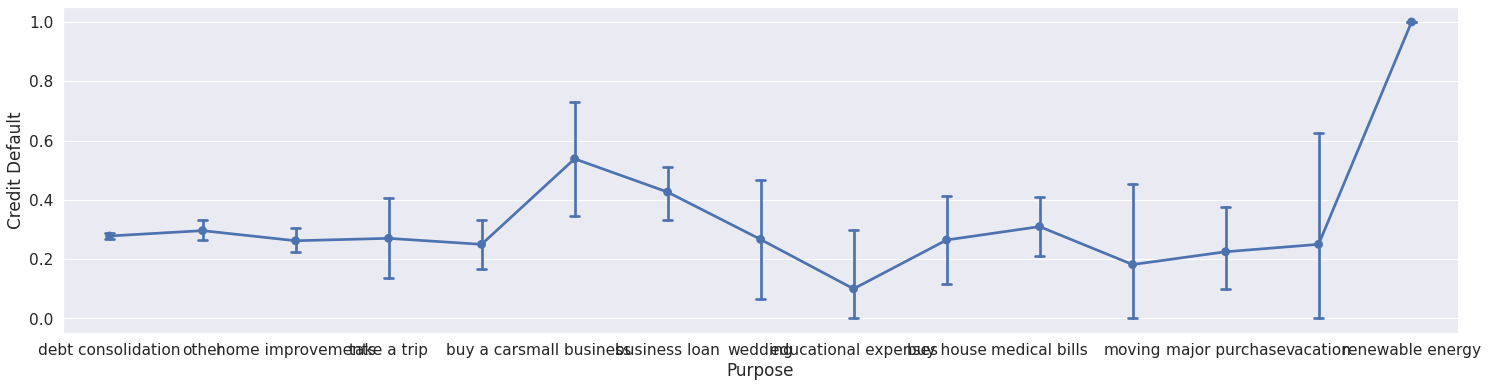

In [98]:
for feature in cat_features:
    plt.figure(figsize=(25, 6))
    sns.pointplot(x=feature, y='Credit Default', data=df, capsize=.1,);

# распределение признака Home Ownership приемлемо
# В признаке Purpose большая часть значений пересекается друг с другом. Объединим некоторые признаки

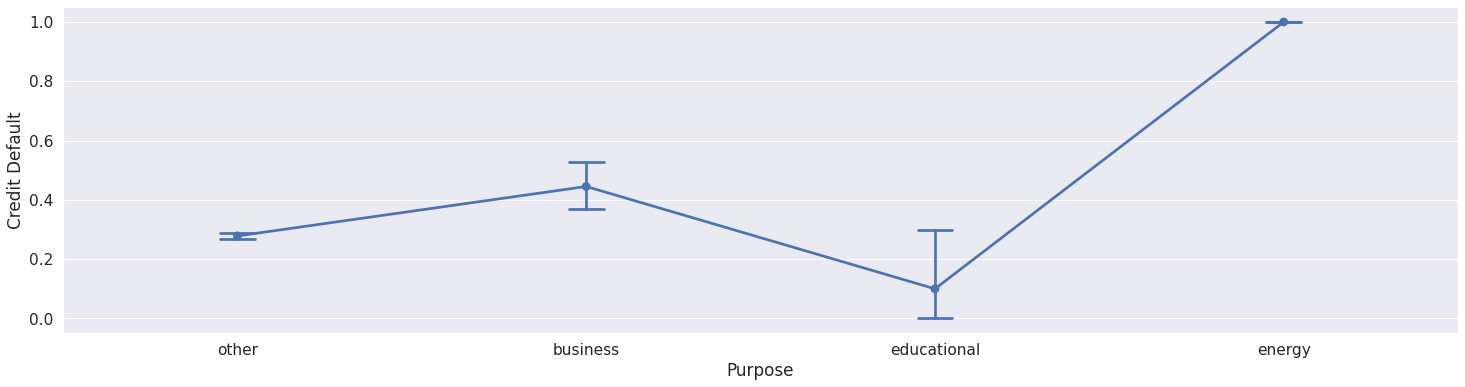

In [99]:
business = ['small business', 'business loan']
educational = ['educational expenses']
other = ['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'wedding', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation']
energy = ['renewable energy']

df.loc[df['Purpose'].isin(business), 'Purpose'] = 'business'
df.loc[df['Purpose'].isin(educational), 'Purpose'] = 'educational'
df.loc[df['Purpose'].isin(other), 'Purpose'] = 'other'
df.loc[df['Purpose'].isin(energy), 'Purpose'] = 'energy'

plt.figure(figsize=(25, 6))
sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1,);

#### Анализ числовых признаков<a id="analysis_num"></a>

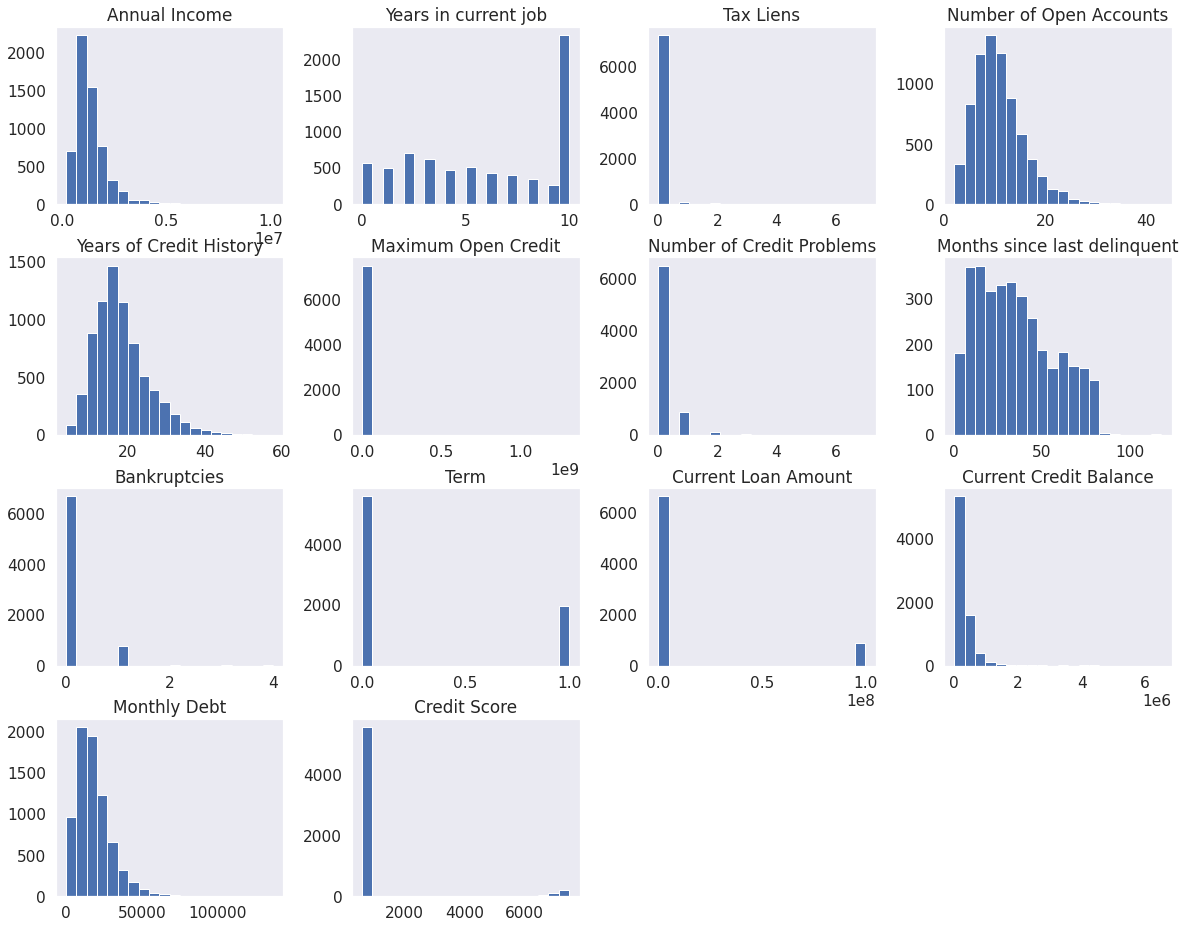

In [100]:
df[num_features].hist(figsize=(20, 16), bins=20, grid=False);

# 10 из 14 признаков имеют выбросы. Проанализируем их дополнительно

,Annual Income
1161660.0,4
1338113.0,4
1043651.0,4
969475.0,4
1058376.0,4
745864.0,3
1405335.0,3
1068313.0,3
1912920.0,3
1297814.0,3


,Квантиль 0.98
0,3753184.0


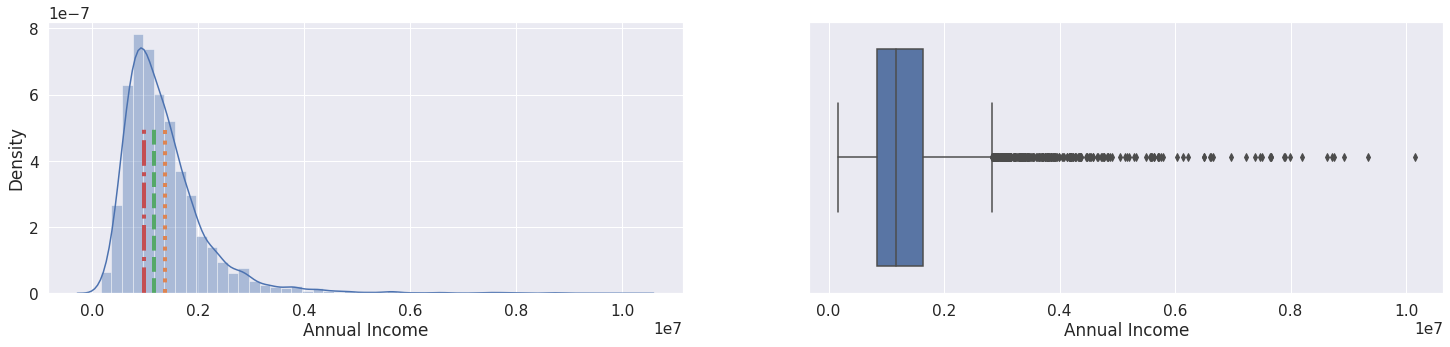

,Tax Liens
0.0,7366
1.0,83
2.0,30
3.0,10
4.0,6
5.0,2
6.0,2
7.0,1


,Квантиль 0.98
0,0.0


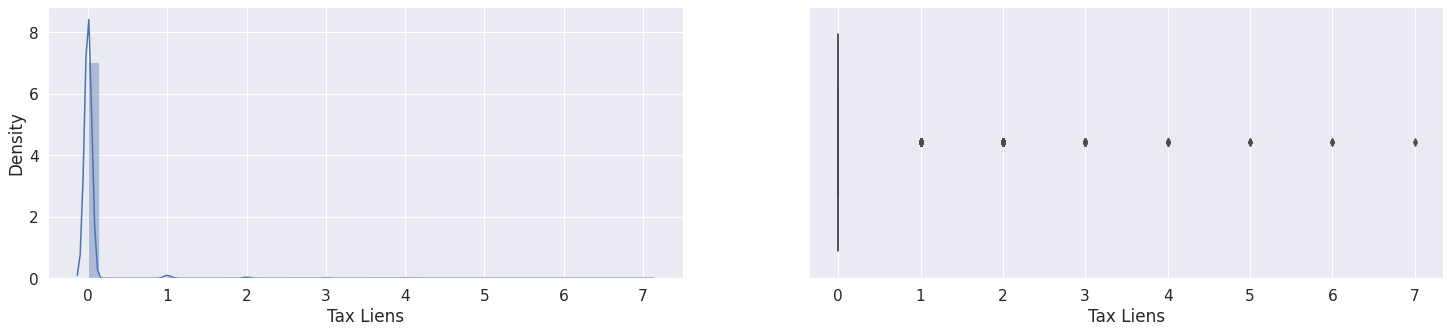

,Number of Open Accounts
9.0,728
11.0,692
10.0,677
8.0,638
7.0,613
12.0,562
6.0,504
13.0,465
14.0,420
5.0,325


,Квантиль 0.98
0,24.0


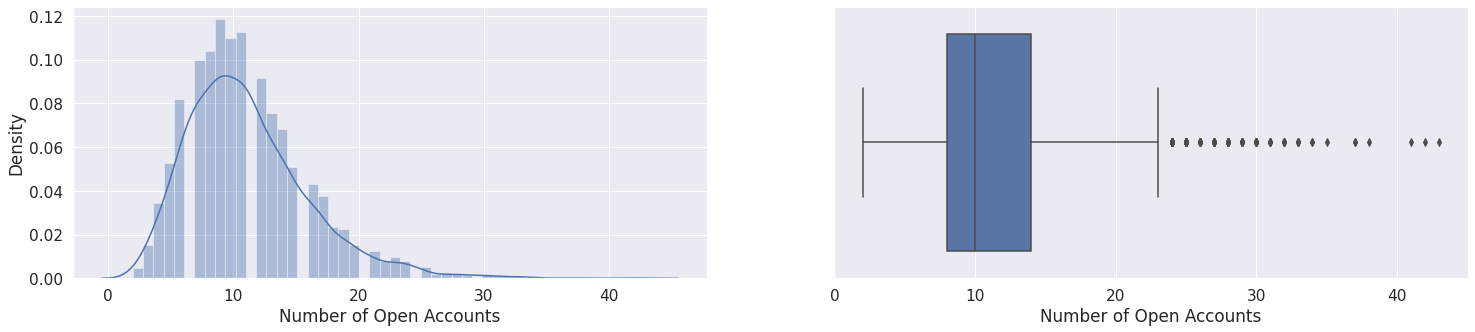

,Years of Credit History
15.0,104
16.0,99
16.5,91
17.0,86
17.5,83
14.0,82
18.0,80
15.4,72
18.5,72
12.0,70


,Квантиль 0.98
0,36.502


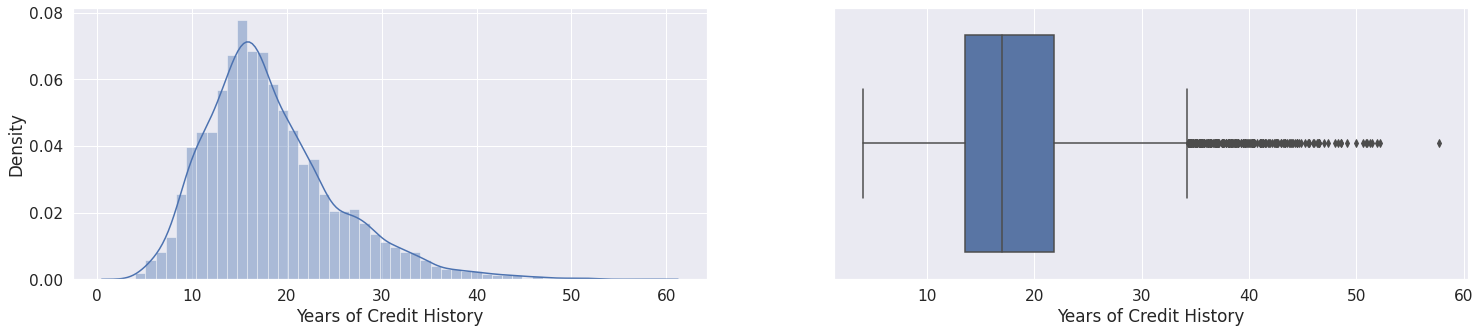

,Maximum Open Credit
0.0,65
319110.0,5
358732.0,3
615714.0,3
323312.0,3
421784.0,3
727958.0,3
487498.0,3
513524.0,3
246224.0,3


,Квантиль 0.98
0,2448540.6


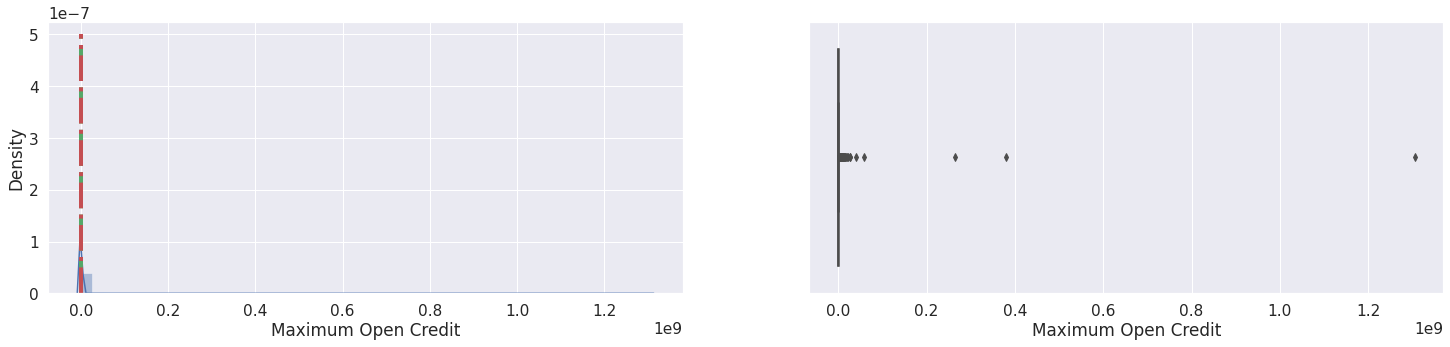

,Number of Credit Problems
0.0,6469
1.0,882
2.0,93
3.0,35
4.0,9
5.0,7
6.0,4
7.0,1


,Квантиль 0.98
0,1.0


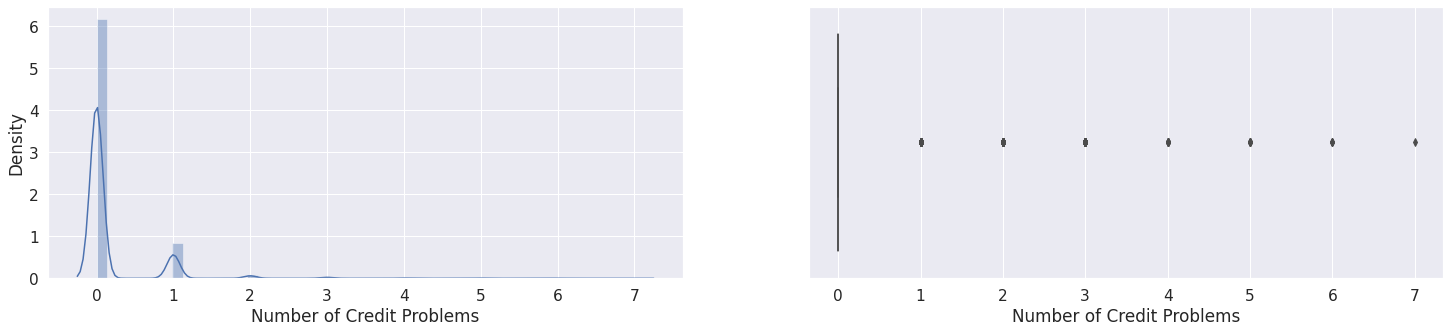

,Bankruptcies
0.0,6660
1.0,786
2.0,31
3.0,7
4.0,2


,Квантиль 0.98
0,1.0


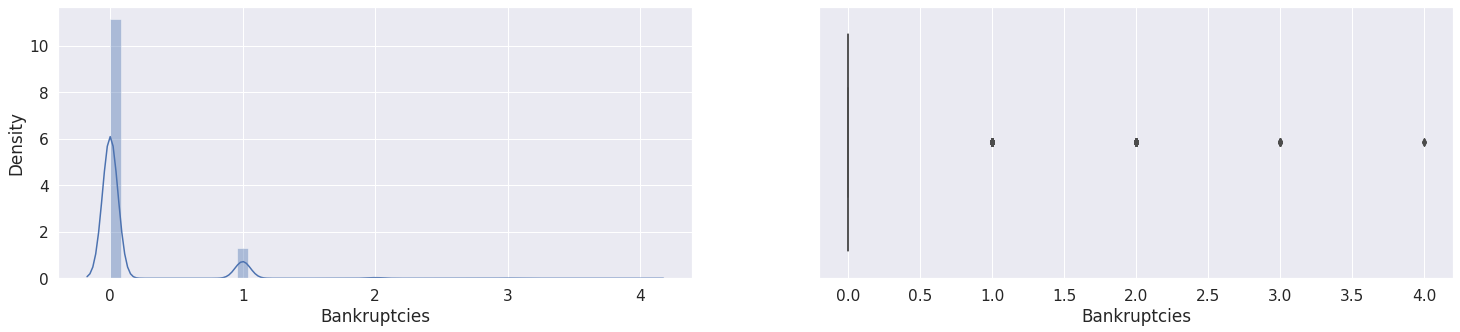

,Current Loan Amount
99999999.0,870
218064.0,6
89298.0,6
216106.0,5
265826.0,5
222926.0,5
223322.0,5
270226.0,5
64526.0,4
267982.0,4


,Квантиль 0.98
0,99999999.0


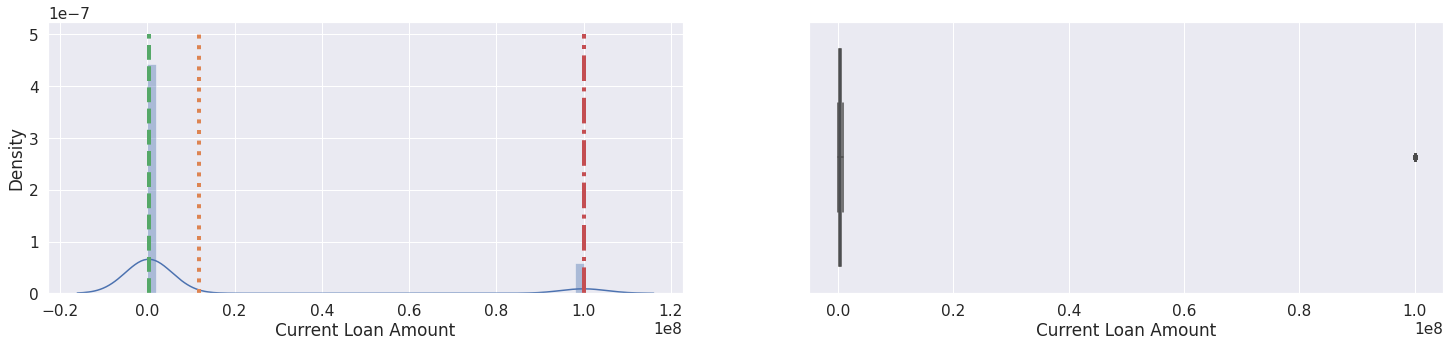

,Current Credit Balance
0.0,53
191710.0,5
53580.0,4
106818.0,4
155059.0,4
82289.0,4
198911.0,4
136401.0,4
83638.0,4
195871.0,3


,Квантиль 0.98
0,1094266.24


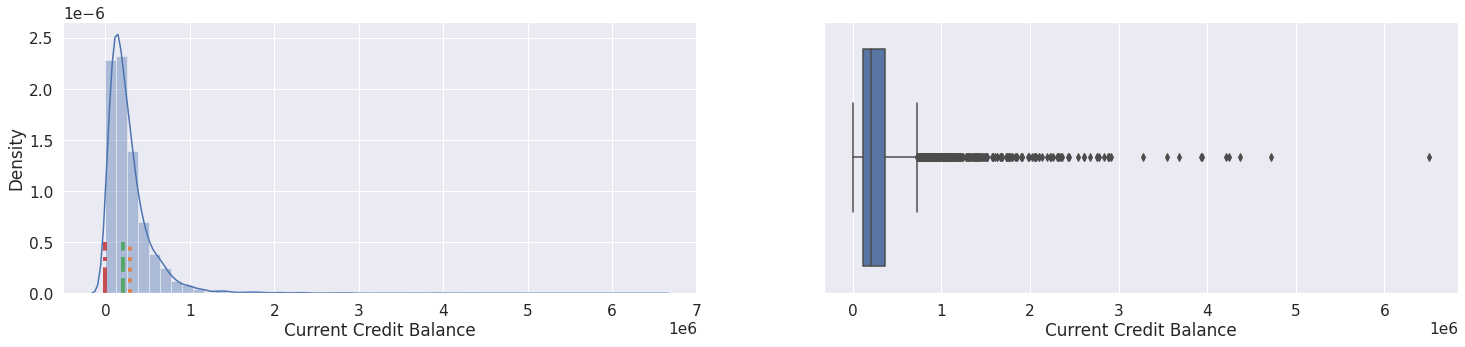

,Monthly Debt
0.0,6
19667.0,4
19222.0,4
11659.0,3
14848.0,3
12343.0,3
6878.0,3
13908.0,3
22813.0,3
7792.0,3


,Квантиль 0.98
0,50484.58


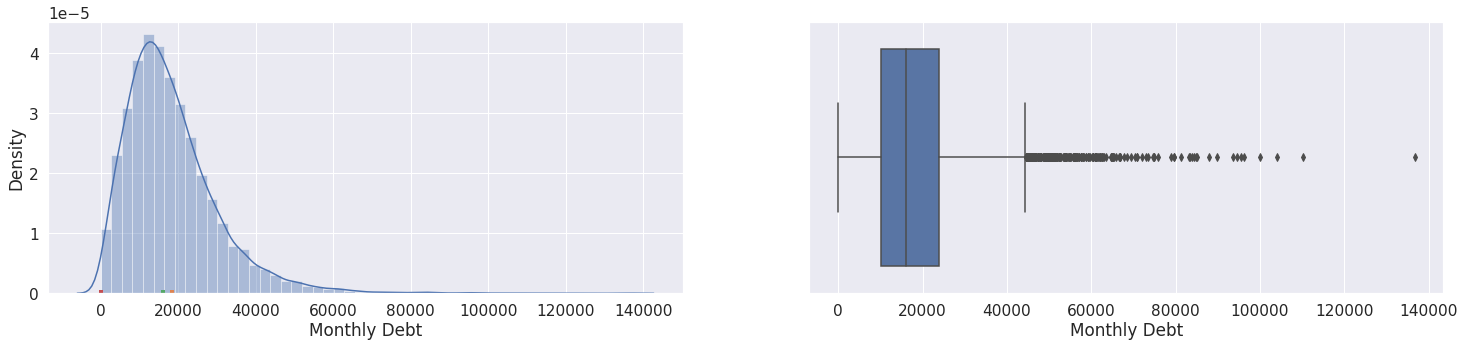

In [101]:
outliers_features = num_features.drop(['Years in current job', 'Months since last delinquent', 'Term', 'Credit Score'])
for feature in outliers_features:
    display(pd.DataFrame(df[feature].value_counts()).sort_values(by=feature, ascending=False).head(10))
    display(pd.DataFrame({'Квантиль 0.98': [df[feature].quantile(.98)]}))
    dis_plot(df, feature)

# Выбранные пороги для выбросов отображены в классе для обработки данных

#### Матрица корреляции<a id="corr_matrix"></a>

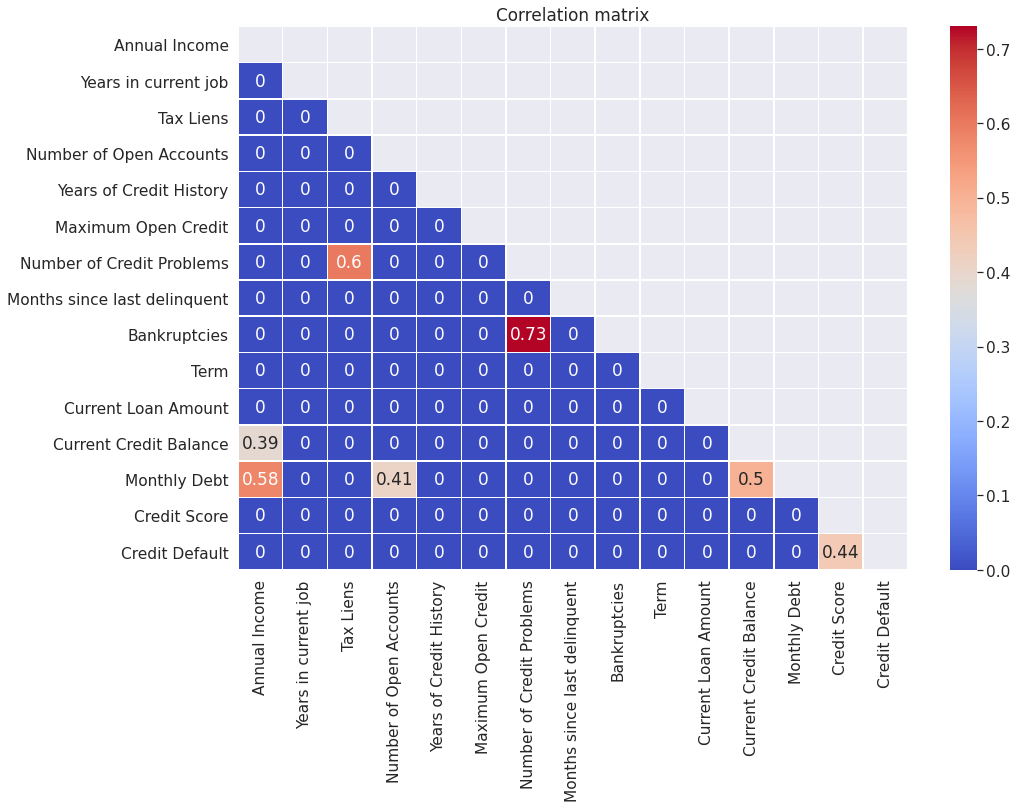

In [104]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### <center>Обработка данных<a id="processing"></a><center>

In [105]:
df = pd.read_csv('course_project_train.csv')
test = pd.read_csv('course_project_test.csv')

data = Data()
data.fit(df)

df = data.transform_train(df)
df = data.feature_generator(df)

test = data.transform_test(test)
test = data.feature_generator(test)

r2 на train: 0.6013261701644042
r2 на test: 0.4235299067178052
r2 на train: 0.3459762292299404
r2 на test: 0.01814917831052909


### <center>Отбор признаков<a id="select_features"></a><center>

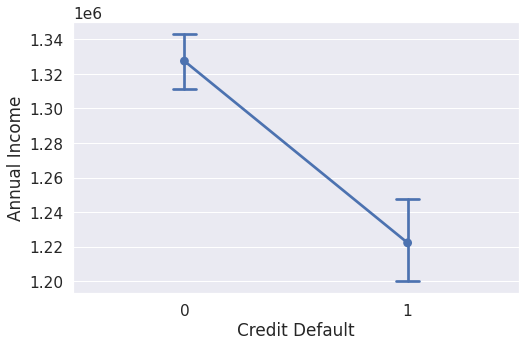

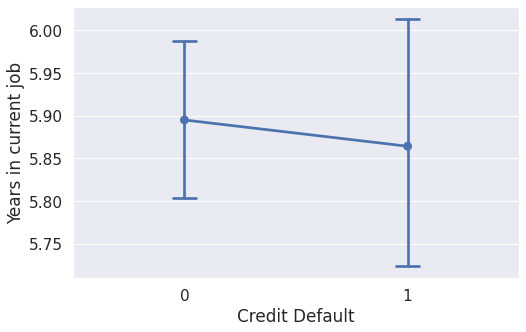

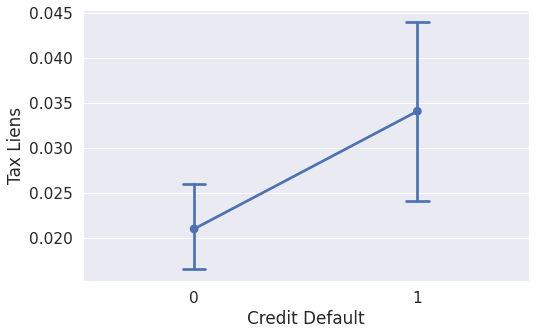

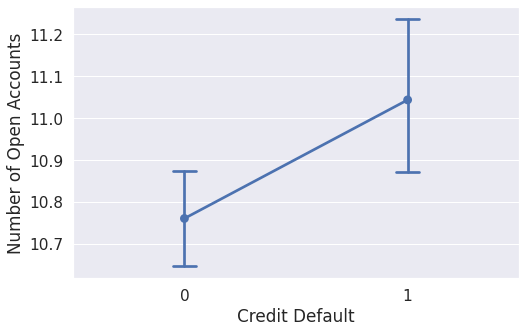

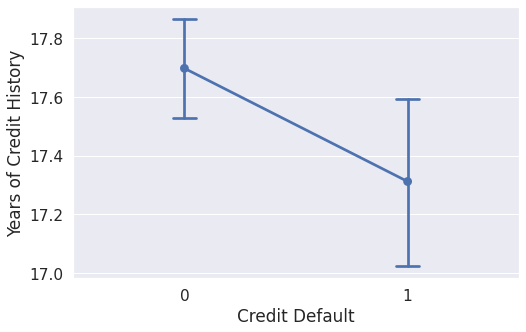

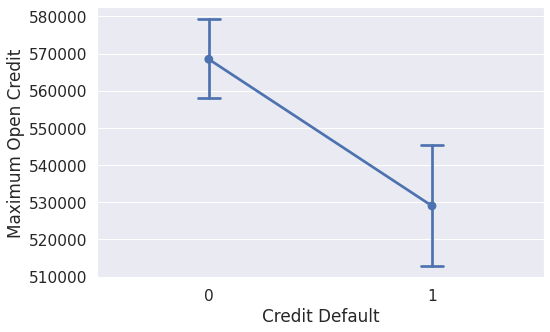

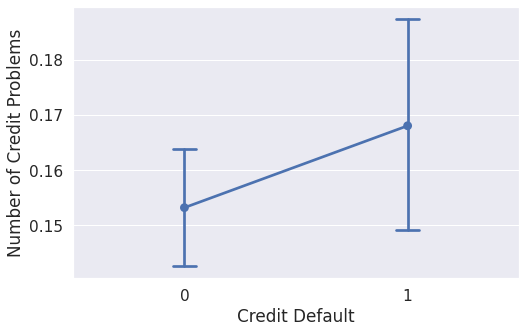

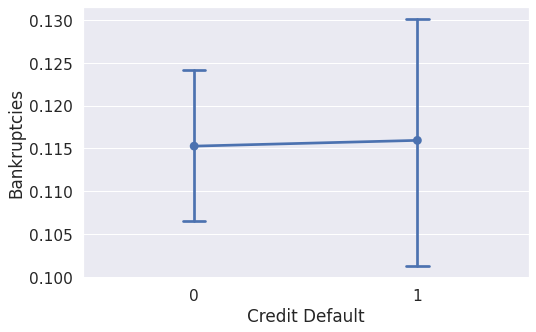

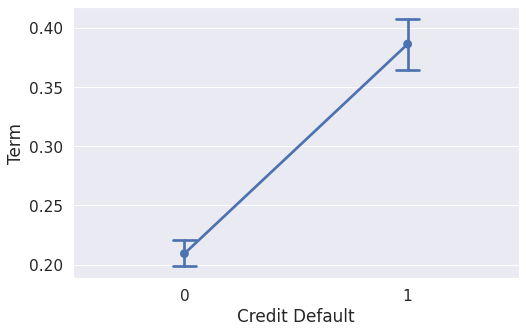

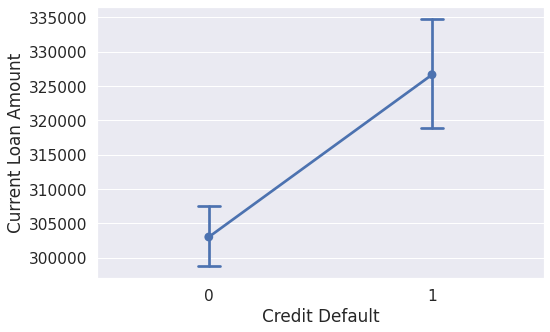

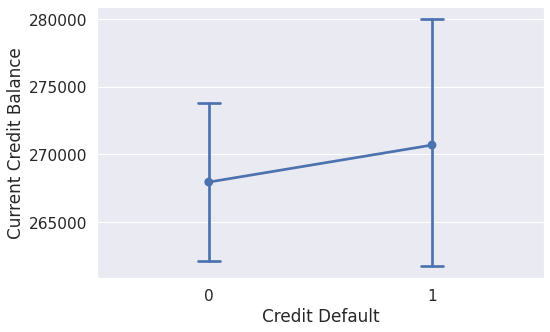

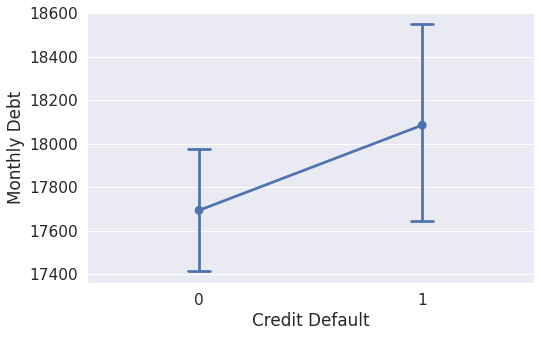

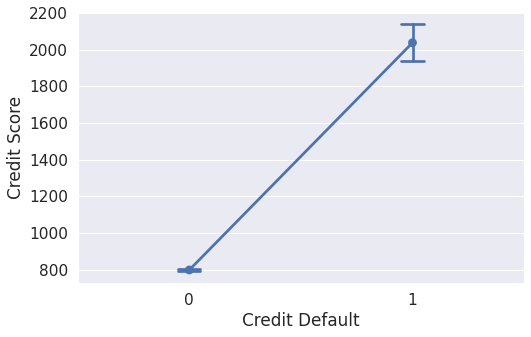

In [106]:
num_features = df.select_dtypes(include=['float64', 'int64']).columns
num_features = num_features.drop('Credit Default')
for feature in num_features:
    point_plot(df, feature)

In [107]:
target = ['Credit Default']

num_base_features = ['Annual Income', 
#                     'Years in current job', #
                     'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
#                     'Months since last delinquent', 
#                     'Bankruptcies',
                     'Term', 'Current Loan Amount',
#                     'Current Credit Balance',#
                     'Monthly Debt', 'Credit Score'
                    ]
dummies_features = ['Home Ownership_Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent']
cat_features = ['Purpose']

### <center>Обучение модели<a id="predict"></a><center>

In [108]:
df = df[dummies_features + num_base_features + cat_features + target]
test = test[dummies_features + num_base_features + cat_features]

X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.1,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

Credit Default
0                 0.718222
1                 0.281778
dtype: float64

Credit Default
0                 0.718667
1                 0.281333
dtype: float64

In [109]:
%%time
# Для подбора гиперпараметров использовался GridSearchCV с StratifiedKFold
# Для борьбы с переобучением используется 'reg_lambda'

disbalance = int(y_train.value_counts()[0]) / int(y_train.value_counts()[1])

params = {
    'cat_features':cat_features,
    'class_weights':[1, disbalance], 
    'silent':True,
    'random_state':21,
    'eval_metric':'F1',
    'early_stopping_rounds':20,
    'learning_rate': 0.04,
    'iterations': 100,
    'max_depth': 7,
    'reg_lambda': 0.6430379746835443
}


model = catb.CatBoostClassifier(**params)

# Обучение на train_test для получения метрик
model.fit(X_train, y_train) 
evaluate_preds(model, X_train, X_test, y_train, y_test)

# Финальное обучение на всем датасете
model.fit(X, y)

# Запись в файл предсказаний на тесте
test_predict(model, test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      4848
           1       0.54      0.64      0.59      1902

    accuracy                           0.74      6750
   macro avg       0.69      0.71      0.70      6750
weighted avg       0.76      0.74      0.75      6750

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       539
           1       0.49      0.61      0.54       211

    accuracy                           0.71       750
   macro avg       0.66      0.68      0.67       750
weighted avg       0.73      0.71      0.72       750

CSV file ready
CPU times: user 2.56 s, sys: 263 ms, total: 2.82 s
Wall time: 1.63 s


### <center>Анализ качества полученной модели<a id="analysis_model"></a><center>

#### Важность признаков<a id="feature_importances"></a>

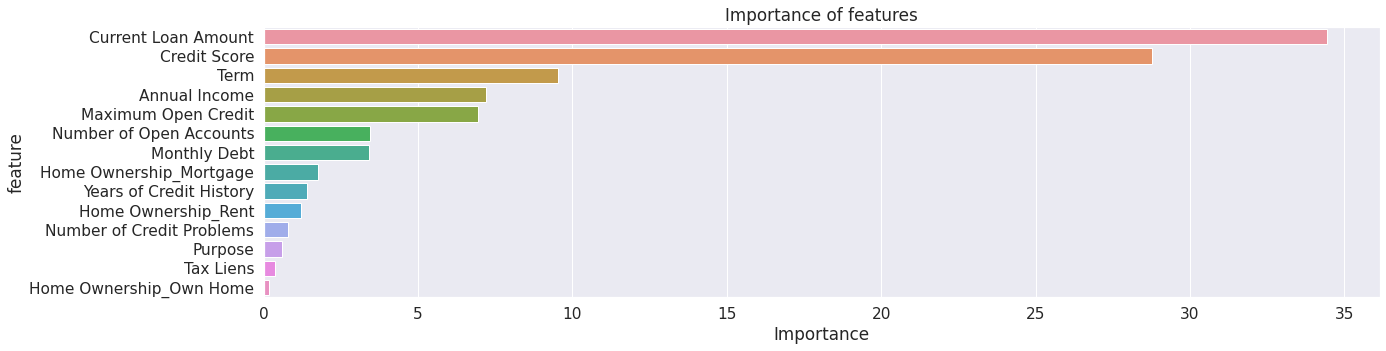

In [110]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=23)

#### Качество предсказаний<a id="model_quality"></a>

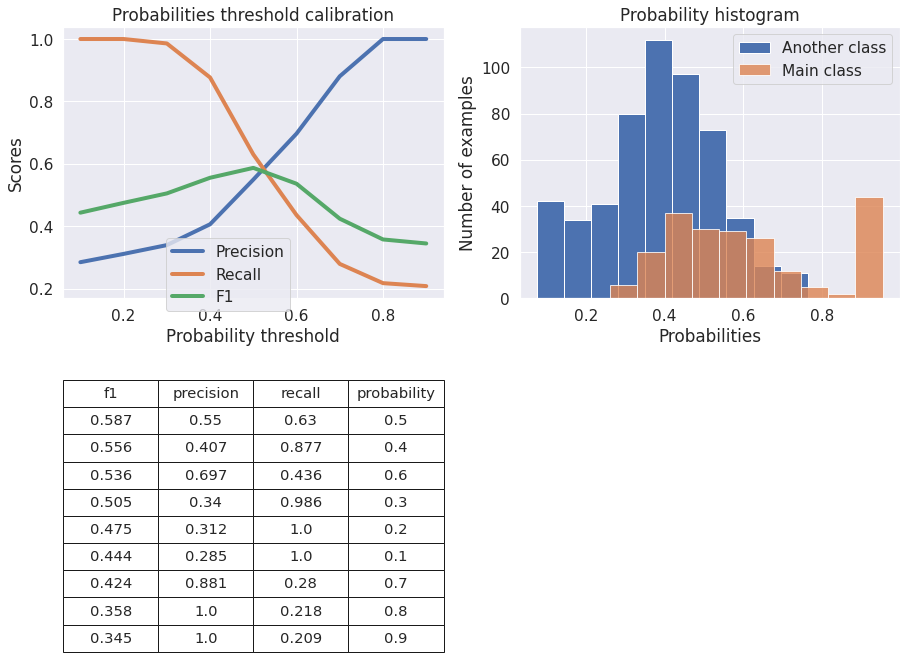

In [111]:
y_test_pred_probs = model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], list(y_test['Credit Default']))